In [44]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import pandas as pd

from nltk.corpus import cmudict

In [7]:
df = pd.read_csv('sample_haiku.csv')
corpus = df['haiku']

In [65]:
# port as util function
def syllables(word):
    # this isn't perfect. example: jesse
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return [count]

d = cmudict.dict()
def nysyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 50
trunc_type='pre'
padding_type='pre'
oov_token = "<OOV>"
training_size = 10000

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 # adding one because we're not using an oov token

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'a': 2, 'of': 3, 'to': 4, 'again': 5, 'world': 6, 'and': 7, 'erase': 8, 'sitting': 9, 'quietly': 10, 'murkrow': 11, 'waits': 12, 'for': 13, 'dinner': 14, 'unlucky': 15, 'ratatta': 16, 'graceful': 17, 'celebi': 18, 'spirit': 19, 'forest': 20, 'can': 21, 'time': 22, 'travel': 23, 'anywhere': 24, 'ekans': 25, 'slithering': 26, 'so': 27, 'close': 28, 'ground': 29, 'he': 30, 'creeps': 31, 'waiting': 32, 'evolve': 33, 'an': 34, 'old': 35, 'silent': 36, 'pond': 37, 'frog': 38, 'jumps': 39, 'into': 40, 'pond—': 41, 'splash': 42, 'silence': 43, 'dew': 44, 'within': 45, 'every': 46, 'dewdrop': 47, 'struggle': 48, 'light': 49, 'candle': 50, 'is': 51, 'transferred': 52, 'another': 53, 'candle—': 54, 'spring': 55, 'twilight': 56, 'i': 57, 'write': 58, 'rewrite': 59, 'then': 60, 'poppy': 61, 'blooms': 62}
63


In [9]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0] # [0] retreives the list, since it's a list within a list
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
    
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
# pad_sequences creates a list within a list
# np.array simply turns it into a numpy array for tf v 2.0
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) 

In [10]:
# input_sequences[:,:-1]
input_sequences[:,-1]

array([10,  1, 11, 12, 13, 14, 15, 16, 18,  1, 19,  3,  1, 20, 21, 22, 23,
       24, 26, 27, 28,  4,  1, 29, 30, 31, 32,  4, 33, 35, 36, 37,  2, 38,
       39, 40,  1, 41, 42, 43,  5,  6,  3, 44,  7, 45, 46, 47,  2,  6,  3,
       48, 49,  3,  2, 50, 51, 52,  4, 53, 54, 55, 56, 58,  8, 59,  8,  5,
        7, 60,  2, 61, 62], dtype=int32)

In [11]:
# create predictors and label
# input_sequence is now a 2D array, which is why you need to slice using [:,:].
    # slice all arrays and in the inner arrays, start from 0 and stop at -1 (aka stop at the last element)
    # the last value will be y, which will be the predicted word

# we want our labels to be categorical and one-hot encoded. What this means is that the label will be 1 and everything else in the array is 0
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [48]:
print(xs)

[[  0   0   0 ...   0   0  65]
 [  0   0   0 ...   0  65 110]
 [  0   0   0 ...  65 110  65]
 ...
 [  0   0   0 ...   3   2   1]
 [  0   0   0 ...   2   1   7]
 [  0   0   0 ...   1   7   5]]


In [49]:
print(labels)

[110  65 111  19  46 112 113  66   4  33 114  26  12 115 116  47  10  34
 117  48   5   9  67  11  26  12 119 120  20  19   4 121 124  20  68  69
  22 125  10 126 127 129 130 131 132  17 133 134  27   9  23  16  13  10
  28   9  49  16  13  10  28   9  50  52  35  40   4  53  16  13   9  23
  54  24   6   3   2   1   7   5   8   6   3   2   1   7   5   8   6   3
   2   1   7   5   8   6   3   2   1   7   5   8  70  71  25  29 135 136
  55  70  71  27 137  72 139  10  73  10  73  12  74 140  14 142  12  22
 143  10 144 145 146   4 147  34 149  30  12 150  27 151 152 153 154  11
 155  56 156  57  40   3 157 158  75  29  76 160  77  48 161  13  75 162
   4 163  57  25 164  27 165   4 166 167 168 169 170  78  78  19 171 172
  80  36  37 173  31  81  29 174  25  29 175  82  12 176 177 178  34  80
 179  25 180 181  12  22   4 182  83  31  58  12 183  20  20  27   9  67
  18  12  22   9 185 186 187  12 188 189  85  85 190 191  68  11  86  47
   9 192 193  83  36 194  11 195 196  18  16  13  1

In [50]:
print(ys)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
# 
print(xs[6])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0  65 110  65 111
  19  46 112]


In [56]:
# 
print(ys[6])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
model = Sequential()

# for my example, since it's a couple of haikus I'm decreasing the dimensions to 200
model.add(Embedding(total_words, 800, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(25)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)


Epoch 1/100
3/3 [==============================] - 1s 8ms/step - loss: 4.1481 - accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 7ms/step - loss: 4.1125 - accuracy: 0.1096
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 4.0871 - accuracy: 0.1507
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 4.0591 - accuracy: 0.1644
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 4.0293 - accuracy: 0.1507
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 3.9955 - accuracy: 0.1233
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 3.9590 - accuracy: 0.1096
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 3.9158 - accuracy: 0.0959
Epoch 9/100
3/3 [==============================] - 0s 10ms/step - loss: 3.8731 - accuracy: 0.0822
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 3.8255 - accuracy: 0.0822
Epoch 11/100
3/3 [=====

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

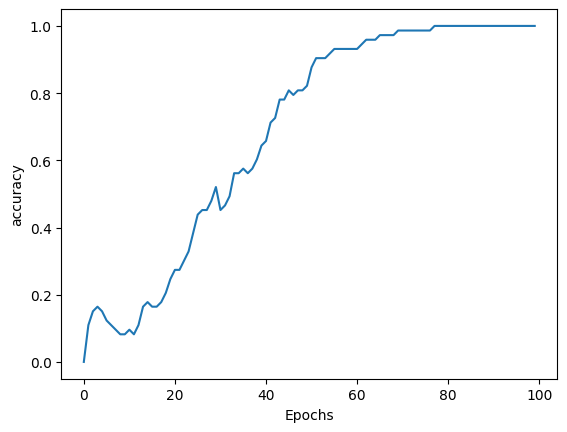

In [29]:
plot_graphs(history, 'accuracy')

In [35]:
seed_text = "The moss on the log"
next_words = 15
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 11ms/step
The moss on the log murkrow waits for dinner unlucky ratatta ratatta ratatta ratatta ratatta ratatta ratatta ratatta ratatta candle—
